# Scraping Cemetery data

In [179]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import time
from tqdm import tqdm

# Function to scrape cemetery data from a specific page
def scrape_page(url):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    
    response = requests.get(url, headers=headers)
    response.encoding = 'utf-8'
    
    if response.status_code != 200:
        print(f"Failed to retrieve page: {url}, status code {response.status_code}")
        return []
    
    soup = BeautifulSoup(response.text, 'html.parser')
    records = []
    
    for item in soup.find_all('div', class_='grave-list-item'):
        try:
            name = item.find('h5').text.strip()
            location = item.find('div', class_='grave-location').text.strip()
            years = item.find('div', class_='grave-years').text.strip()
            img_url = item.find('img')['src'] if item.find('img') else ''
            img_name = item.find('img')['alt'] if item.find('img') else ''
            records.append({
                'name': name,
                'location': location,
                'years': years,
                'img_url': img_url,
                'img_name': img_name
            })
        except Exception as e:
            print(f"Error processing item {item}: {e}")
            pass
    return records

def scrape_all_pages(base_url, start_page=0, max_pages=20):
    all_records = []
    
    for page in range(start_page, max_pages + 1):
        page_url = f"{base_url}&curPos={20 * page}" if page > 1 else base_url        
        page_records = scrape_page(page_url)
        if not page_records:
            print(f"No records found on page {page}. Stopping.")
            break
            
        all_records.extend(page_records)
        print(f"Found {len(page_records)} records on page {page}")
        
        time.sleep(1.)
    
    return all_records


In [180]:
force_load = False


In [181]:
url = "https://toldot.com/life/cemetery/?show_result=1&country=165&city=Пермь&cemetery=40"
if not force_load:
    df = pd.read_csv('perm_cemetery_records.csv')
else:
    prev_df = pd.read_csv('perm_cemetery_records.csv')
    cemetery_records = scrape_all_pages(url, start_page=0, max_pages=100)
    df = pd.concat([prev_df, pd.DataFrame(cemetery_records)], ignore_index=True) 

print(f"Total records scraped: {len(df)}")
display(df.head())
df.to_csv('perm_cemetery_records.csv', index=False, encoding='utf-8-sig')
print("Data saved to 'perm_cemetery_records.csv'")

Total records scraped: 2696


,name,location,years,img_url,img_name
0,Ярова Дина Измайловна,NaN,1912—2006,//toldot.com/images/cemetery/perm/north/IMG_63...,"Ярова Дина Измайловна, Пермь, Северное кладбище"
1,Яновская Серафима Сергеевна,NaN,1908—1984,//toldot.com/images/cemetery/perm/north/IMG_70...,"Яновская Серафима Сергеевна, Пермь, Северное к..."
2,Ямпольская Роня Ароновна,NaN,?—1984,//toldot.com/images/cemetery/perm/north/IMG_73...,"Ямпольская Роня Ароновна, Пермь, Северное клад..."
3,Якушева Полина Абрамовна,NaN,1929—2009,//toldot.com/images/cemetery/perm/north/IMG_62...,"Якушева Полина Абрамовна, Пермь, Северное клад..."
4,Яковлева Мария Михайловна,NaN,1969—1996,//toldot.com/images/cemetery/perm/north/IMG_67...,"Яковлева Мария Михайловна, Пермь, Северное кла..."


Data saved to 'perm_cemetery_records.csv'


In [182]:
def get_year(year, type_='birth'):
    year = year.split('—')[0 if type_ == 'birth' else 1]
    if year.isdigit():
        return int(year)
    else:
        return None
    

df['birth_year'] = df['years'].map(lambda x: get_year(x, 'birth'))
df['death_year'] = df['years'].map(lambda x: get_year(x, 'death'))
df['age'] = df['death_year'] - df['birth_year']
df['age'].describe()


count    2407.000000
mean       71.139593
std        21.893655
min      -713.000000
25%        64.000000
50%        74.000000
75%        81.000000
max       112.000000
Name: age, dtype: float64

In [183]:
df['death_year'].describe()

count    2454.000000
mean     1982.398126
std        21.082758
min      1197.000000
25%      1972.000000
50%      1981.000000
75%      1993.000000
max      2013.000000
Name: death_year, dtype: float64

In [184]:
def get_cemetery_name(img_url): 
    if not isinstance(img_url, str): 
        return None
    elif img_url.startswith('//toldot.com/images/cemetery/perm/north/'): 
        return 'north'
    elif img_url.startswith('//toldot.com/images/cemetery/perm/south/'): 
        return 'south'
    return 'unknown'
    
df['cemetery'] = df.img_url.map(get_cemetery_name)

In [185]:
df.cemetery.describe()

count      2691
unique        2
top       south
freq       1585
Name: cemetery, dtype: object

In [186]:
df.sort_values(['birth_year'])

,name,location,years,img_url,img_name,birth_year,death_year,age,cemetery
1423,Тульбович Фега Гершевна,NaN,1871—1961,//toldot.com/images/cemetery/perm/south/IMG_53...,"Тульбович Фега Гершевна, Пермь, Южное кладбище",1871.0,1961.0,90.0,south
2298,Гойберг Наум Ильич,NaN,1871—1951,//toldot.com/images/cemetery/perm/south/IMG_52...,"Гойберг Наум Ильич, Пермь, Южное кладбище",1871.0,1951.0,80.0,south
1898,Либерман Яков Абрамович,NaN,1871—1971,//toldot.com/images/cemetery/perm/south/IMG_47...,"Либерман Яков Абрамович, Пермь, Южное кладбище",1871.0,1971.0,100.0,south
1833,Матис Хая Хаимовна,NaN,1871—1963,//toldot.com/images/cemetery/perm/south/IMG_53...,"Матис Хая Хаимовна, Пермь, Южное кладбище",1871.0,1963.0,92.0,south
1472,Тверье Хася Соломоновна,NaN,1872—1967,//toldot.com/images/cemetery/perm/south/IMG_48...,"Тверье Хася Соломоновна, Пермь, Южное кладбище",1872.0,1967.0,95.0,south
...,...,...,...,...,...,...,...,...,...
2691,?,NaN,?—?,//toldot.com/images/cemetery/perm/south/IMG_54...,"? , Пермь, Южное кладбище",NaN,NaN,NaN,south
2692,?,NaN,?—?,//toldot.com/images/cemetery/perm/south/IMG_51...,"? , Пермь, Южное кладбище",NaN,NaN,NaN,south
2693,?,NaN,?—?,//toldot.com/images/cemetery/perm/south/IMG_58...,"? , Пермь, Южное кладбище",NaN,NaN,NaN,south
2694,?,NaN,?—?,//toldot.com/images/cemetery/perm/south/IMG_54...,"? , Пермь, Южное кладбище",NaN,NaN,NaN,south


# Visualizations

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.colors import LinearSegmentedColormap

In [194]:
df.sort_values(['name']).tail(10)

,name,location,years,img_url,img_name,birth_year,death_year,age,cemetery
1131,Яновский Пейсах Лейзерович,NaN,1914—1972,//toldot.com/images/cemetery/perm/south/IMG_54...,"Яновский Пейсах Лейзерович, Пермь, Южное кладбище",1914.0,1972.0,58.0,south
1130,Янэт Мария Марковна,NaN,1905—1975,//toldot.com/images/cemetery/perm/south/IMG_58...,"Янэт Мария Марковна, Пермь, Южное кладбище",1905.0,1975.0,70.0,south
1110,Янэт Мария Марковна,NaN,1905—1975,//toldot.com/images/cemetery/perm/south/IMG_58...,"Янэт Мария Марковна, Пермь, Южное кладбище",1905.0,1975.0,70.0,south
0,Ярова Дина Измайловна,NaN,1912—2006,//toldot.com/images/cemetery/perm/north/IMG_63...,"Ярова Дина Измайловна, Пермь, Северное кладбище",1912.0,2006.0,94.0,north
20,Ярова Дина Измайловна,NaN,1912—2006,//toldot.com/images/cemetery/perm/north/IMG_63...,"Ярова Дина Измайловна, Пермь, Северное кладбище",1912.0,2006.0,94.0,north
1129,Ясинская Полина Вениаминовна,NaN,1915—1969,//toldot.com/images/cemetery/perm/south/IMG_44...,"Ясинская Полина Вениаминовна, Пермь, Южное кла...",1915.0,1969.0,54.0,south
1109,Ясинская Полина Вениаминовна,NaN,1915—1969,//toldot.com/images/cemetery/perm/south/IMG_44...,"Ясинская Полина Вениаминовна, Пермь, Южное кла...",1915.0,1969.0,54.0,south
1108,Яснецова Дина Исааковна,NaN,1934—1992,//toldot.com/images/cemetery/perm/south/IMG_58...,"Яснецова Дина Исааковна, Пермь, Южное кладбище",1934.0,1992.0,58.0,south
1128,Яснецова Дина Исааковна,NaN,1934—1992,//toldot.com/images/cemetery/perm/south/IMG_58...,"Яснецова Дина Исааковна, Пермь, Южное кладбище",1934.0,1992.0,58.0,south
1768,низберг Сара Борисовна,NaN,1927—1974,//toldot.com/images/cemetery/perm/south/IMG_43...,"низберг Сара Борисовна, Пермь, Южное кладбище",1927.0,1974.0,47.0,south


In [202]:
df.img_url[2]

'//toldot.com/images/cemetery/perm/north/IMG_7315_sm.JPG'

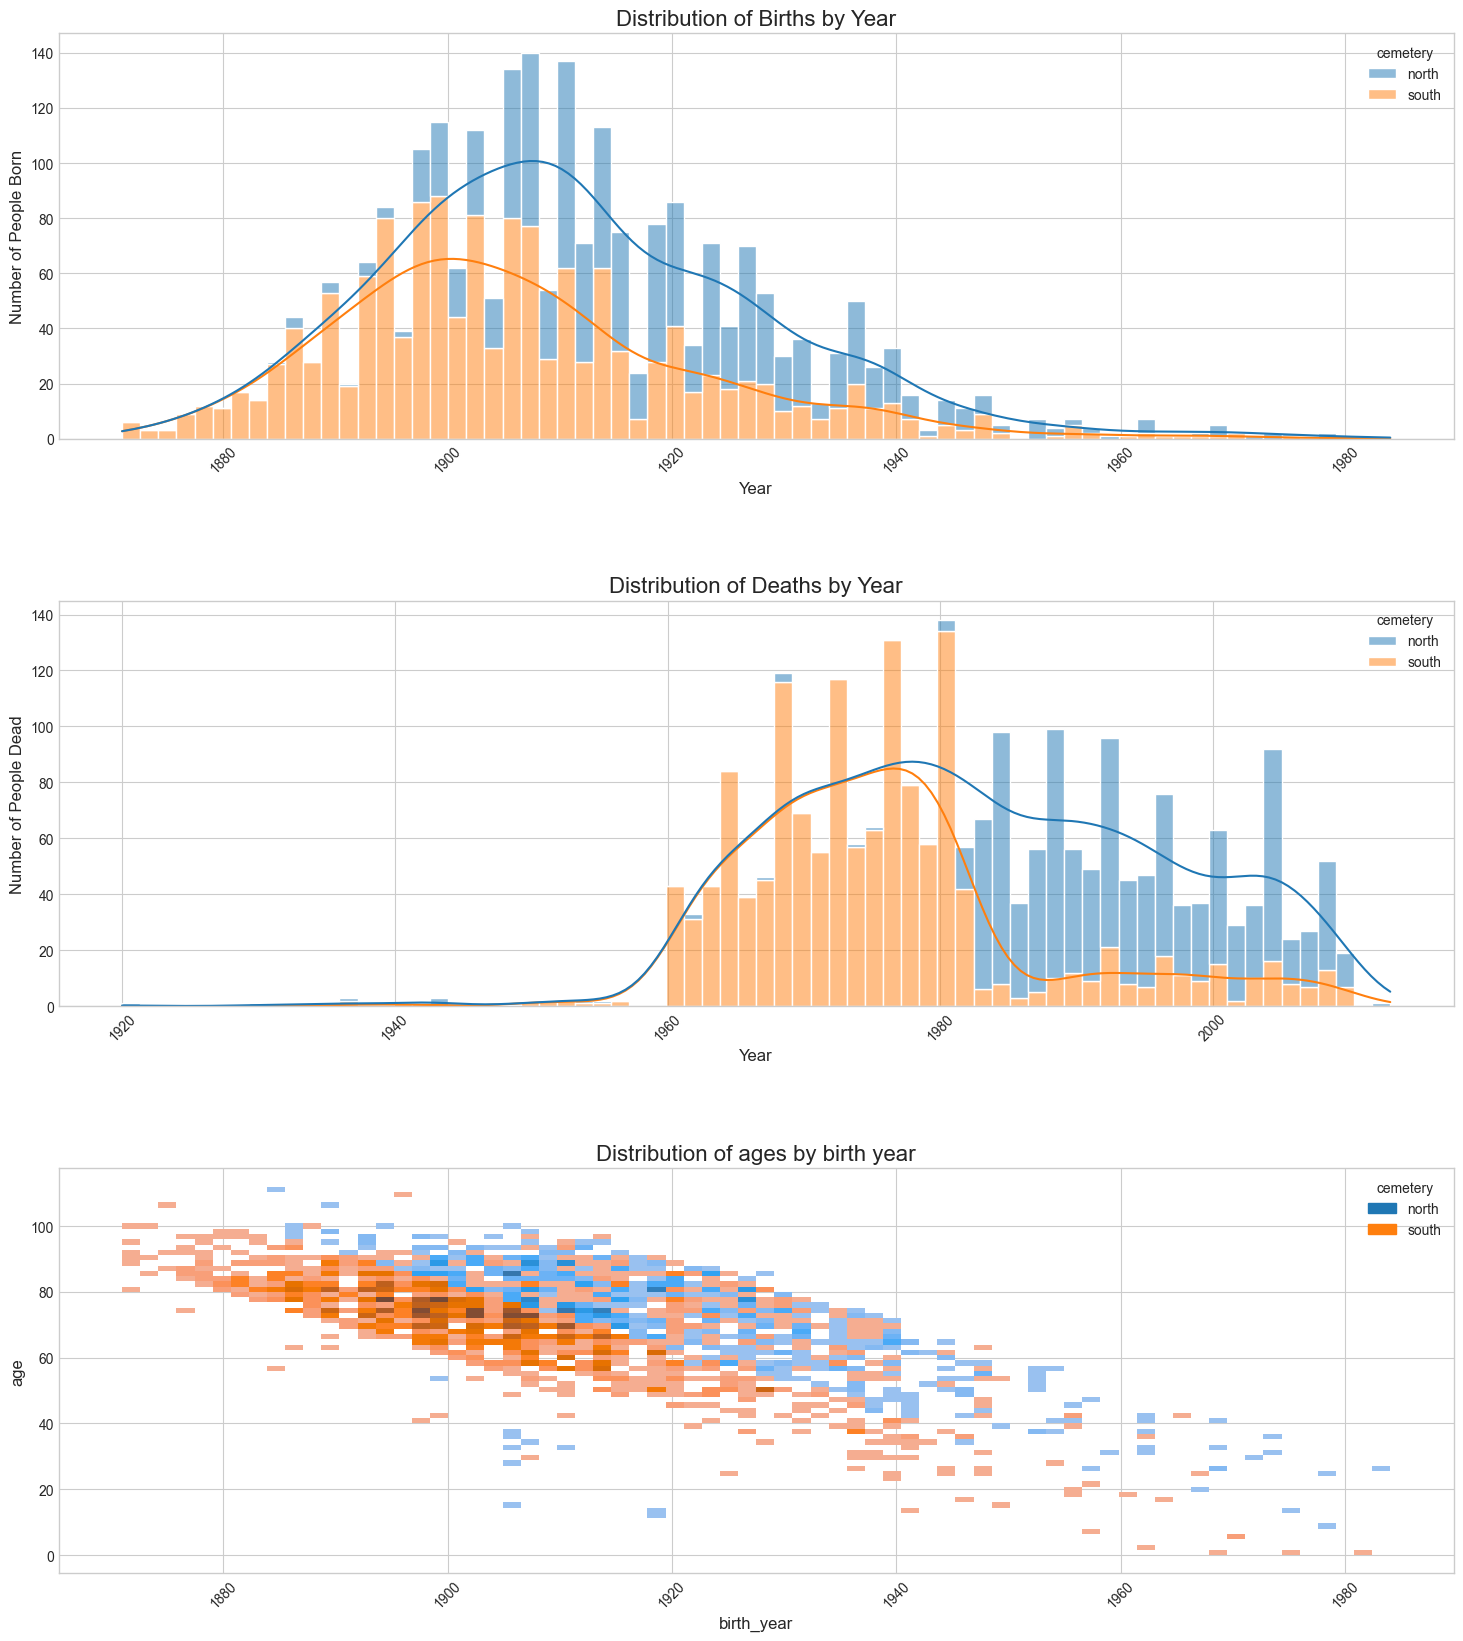

In [ ]:
# Set up the visualization style
plt.style.use('seaborn-v0_8-whitegrid')

# Create figure with subplots
fig = plt.figure(figsize=(18, 20))
plt.subplots_adjust(hspace=0.4)

# 1. BIRTH YEAR DISTRIBUTION HEATMAP
plt.subplot(3, 1, 1)
birth_plot = sns.histplot(x='birth_year', data=df, bins=70, kde=True, hue='cemetery', multiple="stack", edgecolor='white')
plt.title('Distribution of Births by Year', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of People Born', fontsize=12)
plt.xticks(rotation=45)

# 2. Death year distribution
plt.subplot(3, 1, 2)
death_plot = sns.histplot(x='death_year', data=df[df['death_year'].between(1700, 2025)], bins=70, kde=True, hue='cemetery', multiple="stack", edgecolor='white')
plt.title('Distribution of Deaths by Year', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of People Dead', fontsize=12)
plt.xticks(rotation=45)

# 3. Death x Birth year
# 
# plt.subplot(4, 1, 3)
# death_birth_plot = sns.histplot(x='death_year', y='birth_year', data=df, bins=70, kde=True, hue='cemetery')
# plt.title('Distribution of Births years by Death Year', fontsize=16)
# plt.xlabel('Death year', fontsize=12)
# plt.ylabel('Birth year', fontsize=12)
# plt.xticks(rotation=45)

# 4. Age distribution by year of death
plt.subplot(3, 1, 3)
birth_plot = sns.histplot(x='birth_year', y='age', data=df[df['age'].between(0, 120)], bins=70, kde=True, hue='cemetery', edgecolor='white', linewidth=0)
plt.title('Distribution of ages by birth year', fontsize=16)
plt.xlabel('birth_year', fontsize=12)
plt.ylabel('age', fontsize=12)
plt.xticks(rotation=45)

plt.show()


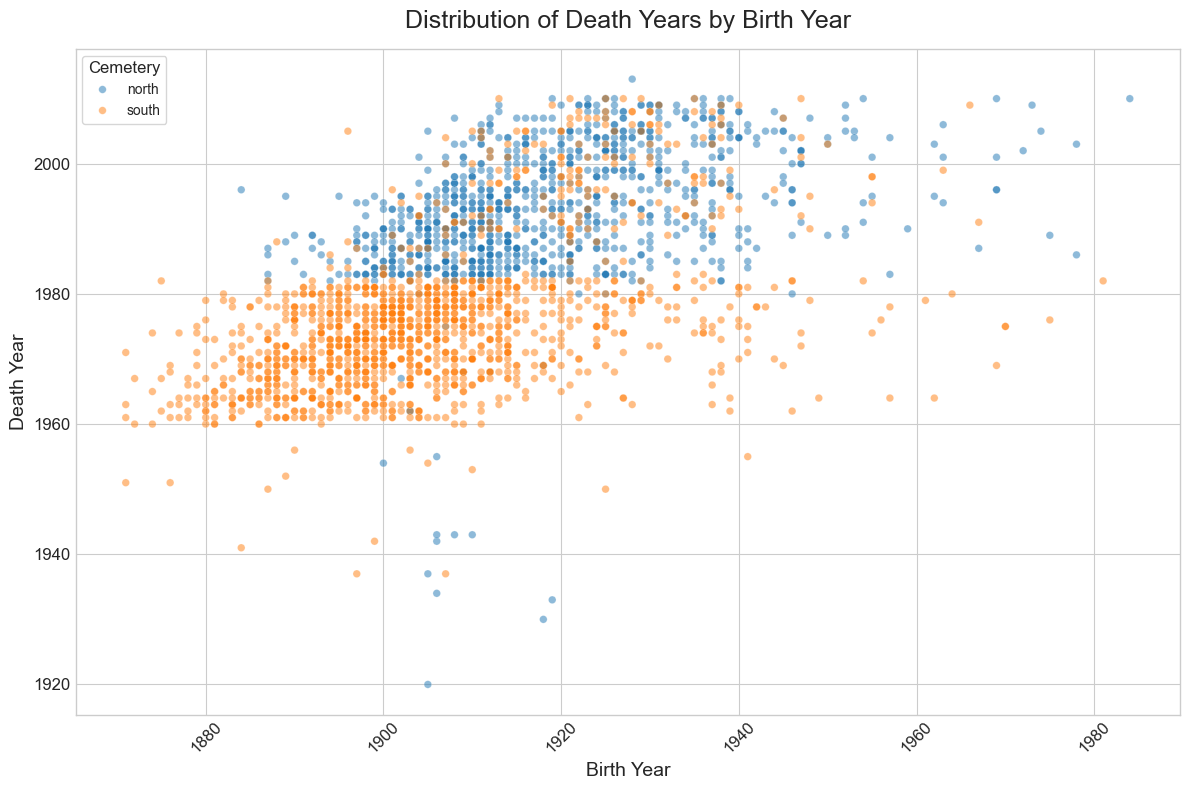

In [230]:

sns.set_style("whitegrid")

# Create figure and axes
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1)

# Adjust spacing
plt.subplots_adjust(hspace=0.4)

# Scatterplot
birth_plot = sns.scatterplot(
    x='birth_year',
    y='death_year',
    data=df[df['age'].between(0, 120)],
    hue='cemetery',
    edgecolor='white',
    linewidth=0.3,
    s=30,            # smaller marker size
    alpha=0.5,       # slight transparency
    ax=ax
)

# Titles and labels
ax.set_title('Distribution of Death Years by Birth Year', fontsize=18, pad=15)
ax.set_xlabel('Birth Year', fontsize=14)
ax.set_ylabel('Death Year', fontsize=14)
ax.tick_params(axis='x', rotation=45)
ax.tick_params(axis='both', labelsize=12)

# Legend
ax.legend(title='Cemetery', title_fontsize=12, fontsize=10, loc='best', frameon=True)

# Tight layout
plt.tight_layout()
plt.show()


In [ ]:
df.groupby(['name']).max()

,location,years,img_url,img_name,birth_year,death_year,age,cemetery,birth_decade,death_decade,age_category,surnames,surname,first_name
name,,,,,,,,,,,,,,
?,NaN,1944—1994,//toldot.com/images/cemetery/perm/south/IMG_57...,"? , Пермь, Южное кладбище",1944.0,2006.0,77.0,south,1940s,2000s,70-79,?,?,
? Аврам Израилевич,NaN,1912—1990,//toldot.com/images/cemetery/perm/south/IMG_52...,"? Аврам Израилевич, Пермь, Южное кладбище",1912.0,1990.0,78.0,south,1910s,1990s,70-79,?,?,аврам
? Бейля Абрамовна,NaN,1910—1983,//toldot.com/images/cemetery/perm/north/IMG_73...,"? Бейля Абрамовна, Пермь, Северное кладбище",1910.0,1983.0,73.0,north,1910s,1980s,70-79,?,?,бейля
? Вениамин,NaN,1894—1971,//toldot.com/images/cemetery/perm/south/IMG_56...,"? Вениамин , Пермь, Южное кладбище",1894.0,1971.0,77.0,south,1890s,1970s,70-79,?,?,вениамин
? Григорий Григорьевич,NaN,1905—1989,//toldot.com/images/cemetery/perm/north/IMG_68...,"? Григорий Григорьевич, Пермь, Северное кладбище",1905.0,1989.0,84.0,north,1900s,1980s,80-89,?,?,григорий
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Янэт Мария Марковна,NaN,1905—1975,//toldot.com/images/cemetery/perm/south/IMG_58...,"Янэт Мария Марковна, Пермь, Южное кладбище",1905.0,1975.0,70.0,south,1900s,1970s,60-69,Янэт,янэт,мария
Ярова Дина Измайловна,NaN,1912—2006,//toldot.com/images/cemetery/perm/north/IMG_63...,"Ярова Дина Измайловна, Пермь, Северное кладбище",1912.0,2006.0,94.0,north,1910s,2000s,90-99,Ярова,ярова,дина
Ясинская Полина Вениаминовна,NaN,1915—1969,//toldot.com/images/cemetery/perm/south/IMG_44...,"Ясинская Полина Вениаминовна, Пермь, Южное кла...",1915.0,1969.0,54.0,south,1910s,1960s,50-59,Ясинская,ясинская,полина


In [304]:
df.sort_values(['name'])

,name,location,years,img_url,img_name,birth_year,death_year,age,cemetery,birth_decade,death_decade,age_category,surnames,surname,first_name
1044,?,NaN,1925—2002,//toldot.com/images/cemetery/perm/north/IMG_65...,"? , Пермь, Северное кладбище",1925.0,2002.0,77.0,north,1920s,2000s,70-79,?,?,?
2679,?,NaN,1906—1977,//toldot.com/images/cemetery/perm/south/IMG_51...,"? , Пермь, Южное кладбище",1906.0,1977.0,71.0,south,1900s,1970s,70-79,?,?,?
2624,?,NaN,1899—1966,//toldot.com/images/cemetery/perm/south/IMG_46...,"? , Пермь, Южное кладбище",1899.0,1966.0,67.0,south,1890s,1960s,60-69,?,?,?
1058,?,NaN,1944—1994,//toldot.com/images/cemetery/perm/north/IMG_70...,"? , Пермь, Северное кладбище",1944.0,1994.0,50.0,north,1940s,1990s,40-49,?,?,?
1041,?,NaN,1910—1983,//toldot.com/images/cemetery/perm/north/IMG_69...,"? , Пермь, Северное кладбище",1910.0,1983.0,73.0,north,1910s,1980s,70-79,?,?,?
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1129,Ясинская Полина Вениаминовна,NaN,1915—1969,//toldot.com/images/cemetery/perm/south/IMG_44...,"Ясинская Полина Вениаминовна, Пермь, Южное кла...",1915.0,1969.0,54.0,south,1910s,1960s,50-59,Ясинская,ясинская,полина
1109,Ясинская Полина Вениаминовна,NaN,1915—1969,//toldot.com/images/cemetery/perm/south/IMG_44...,"Ясинская Полина Вениаминовна, Пермь, Южное кла...",1915.0,1969.0,54.0,south,1910s,1960s,50-59,Ясинская,ясинская,полина
1108,Яснецова Дина Исааковна,NaN,1934—1992,//toldot.com/images/cemetery/perm/south/IMG_58...,"Яснецова Дина Исааковна, Пермь, Южное кладбище",1934.0,1992.0,58.0,south,1930s,1990s,50-59,Яснецова,яснецова,дина
1128,Яснецова Дина Исааковна,NaN,1934—1992,//toldot.com/images/cemetery/perm/south/IMG_58...,"Яснецова Дина Исааковна, Пермь, Южное кладбище",1934.0,1992.0,58.0,south,1930s,1990s,50-59,Яснецова,яснецова,дина


In [313]:
def get_surname(name):
    surname = name.split()[0].lower() if name else '?'
    if surname.endswith('а'):
        return surname[:-1]
    elif surname.endswith('ая') or surname.endswith('ий'):
        return surname[:-2]
    return surname


df['surname'] = df['name'].map(get_surname)
df['first_name'] = df['name'].map(lambda elem: elem.split()[1].lower() if ' ' in elem else '?')

df['surname'].describe()


/var/folders/mn/8r_12m8n1y75d0fl9flz99x0kn3184/T/ipykernel_21772/2501436087.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['surname'] = df['name'].map(get_surname)
/var/folders/mn/8r_12m8n1y75d0fl9flz99x0kn3184/T/ipykernel_21772/2501436087.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['first_name'] = df['name'].map(lambda elem: elem.split()[1].lower() if ' ' in elem else '?')


count      2403
unique     1331
top       левин
freq         23
Name: surname, dtype: object

In [314]:
from collections import Counter

surnames = Counter(df.surname)
names = Counter(df.first_name)

In [315]:
surnames.most_common(30)

[('левин', 23),
 ('фридман', 16),
 ('?', 16),
 ('шапиро', 15),
 ('коган', 14),
 ('тульбович', 13),
 ('гуревич', 12),
 ('яблоновск', 10),
 ('фельдман', 9),
 ('розенберг', 9),
 ('златкин', 9),
 ('берлин', 9),
 ('шпигель', 8),
 ('шварц', 8),
 ('симанович', 8),
 ('леви', 8),
 ('геллер', 8),
 ('тверье', 8),
 ('типографов', 7),
 ('рутман', 7),
 ('рапопорт', 7),
 ('каплан', 7),
 ('зак', 7),
 ('гутин', 7),
 ('гельфанд', 7),
 ('бейлин', 7),
 ('яновск', 6),
 ('тевелев', 6),
 ('стерн', 6),
 ('рабинович', 6)]

In [316]:
names.most_common(30)

[('михаил', 57),
 ('мария', 56),
 ('абрам', 53),
 ('софья', 50),
 ('раиса', 48),
 ('борис', 47),
 ('анна', 45),
 ('иосиф', 44),
 ('лев', 42),
 ('рахиль', 42),
 ('сарра', 38),
 ('григорий', 38),
 ('берта', 36),
 ('яков', 34),
 ('моисей', 29),
 ('давид', 27),
 ('ида', 26),
 ('любовь', 25),
 ('роза', 25),
 ('исаак', 25),
 ('рива', 24),
 ('семен', 24),
 ('владимир', 23),
 ('фаина', 23),
 ('самуил', 21),
 ('леонид', 20),
 ('израиль', 20),
 ('александр', 20),
 ('хана', 19),
 ('ефим', 19)]

In [317]:
surnames['гольдберг']

5

In [318]:
df.sort_values(['surname', 'birth_year']).head(50)

,name,location,years,img_url,img_name,birth_year,death_year,age,cemetery,birth_decade,death_decade,age_category,surnames,surname,first_name
2689,? Фаня Моисеевна,NaN,1891—1981,//toldot.com/images/cemetery/perm/south/IMG_51...,"? Фаня Моисеевна, Пермь, Южное кладбище",1891.0,1981.0,90.0,south,1890s,1980s,80-89,?,?,фаня
2628,? Вениамин,NaN,1894—1971,//toldot.com/images/cemetery/perm/south/IMG_56...,"? Вениамин , Пермь, Южное кладбище",1894.0,1971.0,77.0,south,1890s,1970s,70-79,?,?,вениамин
2624,?,NaN,1899—1966,//toldot.com/images/cemetery/perm/south/IMG_46...,"? , Пермь, Южное кладбище",1899.0,1966.0,67.0,south,1890s,1960s,60-69,?,?,?
1106,? Григорий Григорьевич,NaN,1905—1989,//toldot.com/images/cemetery/perm/north/IMG_68...,"? Григорий Григорьевич, Пермь, Северное кладбище",1905.0,1989.0,84.0,north,1900s,1980s,80-89,?,?,григорий
2681,?,NaN,1905—1974,//toldot.com/images/cemetery/perm/south/IMG_57...,"? , Пермь, Южное кладбище",1905.0,1974.0,69.0,south,1900s,1970s,60-69,?,?,?
2679,?,NaN,1906—1977,//toldot.com/images/cemetery/perm/south/IMG_51...,"? , Пермь, Южное кладбище",1906.0,1977.0,71.0,south,1900s,1970s,70-79,?,?,?
1041,?,NaN,1910—1983,//toldot.com/images/cemetery/perm/north/IMG_69...,"? , Пермь, Северное кладбище",1910.0,1983.0,73.0,north,1910s,1980s,70-79,?,?,?
1082,? Бейля Абрамовна,NaN,1910—1983,//toldot.com/images/cemetery/perm/north/IMG_73...,"? Бейля Абрамовна, Пермь, Северное кладбище",1910.0,1983.0,73.0,north,1910s,1980s,70-79,?,?,бейля
2614,? Аврам Израилевич,NaN,1912—1990,//toldot.com/images/cemetery/perm/south/IMG_52...,"? Аврам Израилевич, Пермь, Южное кладбище",1912.0,1990.0,78.0,south,1910s,1990s,70-79,?,?,аврам
1089,? Лэя Соломоновна,NaN,1915—1984,//toldot.com/images/cemetery/perm/north/IMG_73...,"? Лэя Соломоновна, Пермь, Северное кладбище",1915.0,1984.0,69.0,north,1910s,1980s,60-69,?,?,лэя


# Vk Data
https://dev.vk.com/ru/method/users.get


In [553]:
import os
token = os.environ.get('VK_TOKEN')
if not token:
    raise ValueError("VK_TOKEN is not set")


In [ ]:
url = 'https://api.vk.com/method/users.get'
params = {
    'user_ids': '1',
    'fields': 'photo_200',
    'access_token': token,
    'v': '5.131'
}

response = requests.get(url, params=params)
data = response.json()
print(data)



{'response': [{'id': 1, 'photo_200': 'https://sun9-20.userapi.com/s/v1/ig1/xlCOvrlveDwYITME4iAWlYf4_jNBernRJnvEWh6hAF-OuonQdtLXW4zSwfC55ZaBP4y5t0jh.jpg?quality=96&crop=514,119,337,337&as=32x32,48x48,72x72,108x108,160x160,240x240&ava=1&cs=200x200', 'first_name': 'Pavel', 'last_name': 'Durov', 'can_access_closed': True, 'is_closed': False}]}


In [607]:
from datetime import datetime, timedelta
import sys

start_time = int(datetime(2025, 1, 1).timestamp())
end_time = int(datetime(2025, 6, 28).timestamp())
delta = 3600 * 24

In [608]:
def get_photos(start_time, end_time, lat, long, radius=5000):
    url = 'https://api.vk.com/method/photos.search'
    all_items = []
    offset = 0
    params = {
        'access_token': token,
        'v': '5.131',
        'sort': 1,
        'lat': lat,
        'long': long,
        'radius': radius,
        'start_time': start_time,
        'end_time': end_time,
        'offset': offset,
        'count': 50,
    }
    while True:
        response = requests.get(url, params=params)
        data = response.json()
        items = data['response']['items']
        count = data['response']['count']
        all_items.extend(items)
        print(f'\rSo we have {len(items)}/{count} photos. {len(all_items)} total.   ', end='')
        if len(items) == 0:
            break
        offset += 50
        params['offset'] = offset

    return all_items



In [609]:
while start_time < end_time:
    items.extend(get_photos(start_time, start_time + delta, lat, long))
    start_time += delta
len(items)

So we have 0/0 photos. 0 total.   .    

78217

In [617]:
filtered_items = []
links = set()
for item in items:
    if item['sizes'][-1]['url'] not in links:
        links.add(item['sizes'][-1]['url'])
        filtered_items.append(item)
len(filtered_items)

69409

In [622]:
import math

def distance(lat1, long1, lat2, long2):
    return math.sqrt((lat1 - lat2) ** 2 + (long1 - long2) ** 2)

def get_user_id(item):
    if not pd.isna(item['user_id']) and item['user_id'] != 100:
        return int(item['user_id'])
    return int(item['owner_id']) if item.get('owner_id') else None


df = pd.DataFrame(filtered_items)
df['link'] = df.apply(lambda row: row['sizes'][-1]['url'], axis=1)
df['user_id'] = df.apply(lambda row: get_user_id(row), axis=1)
df['distance'] = df.apply(lambda row: distance(row['lat'], row['long'], lat, long), axis=1)
df.to_csv('photos.csv', index=False)

In [619]:
df.head()

,album_id,date,id,owner_id,lat,long,sizes,text,user_id,web_view_token,has_tags,orig_photo,square_crop,post_id,link
0,308889138,1748371915,457240980,-215570596,58.010006,56.210007,"[{'height': 75, 'type': 's', 'width': 56, 'url...",,315786491,59fdd5373ac45464de,False,"{'height': 2560, 'type': 'base', 'url': 'https...",NaN,NaN,https://sun9-6.userapi.com/s/v1/ig2/InTP3qMssT...
1,-7,1748332500,457256927,-54867647,58.008101,56.202322,"[{'height': 56, 'type': 's', 'width': 75, 'url...",,-54867647,f6e4f3d36982281eef,False,"{'height': 1927, 'type': 'base', 'url': 'https...",NaN,NaN,https://sun9-61.userapi.com/s/v1/if2/6s1NLjUWo...
2,-7,1748344395,457239194,-228045900,58.003300,56.266098,"[{'height': 56, 'type': 's', 'width': 75, 'url...",,-228045900,479915cb2cc1f23c07,False,"{'height': 1920, 'type': 'base', 'url': 'https...",NaN,NaN,https://sun9-80.userapi.com/s/v1/if2/62HY1ZW9k...
3,304568942,1748369703,457257127,-210959139,58.018011,56.250873,"[{'height': 75, 'type': 's', 'width': 56, 'url...",,-210959139,61f4142fd506e0bcbb,False,"{'height': 2560, 'type': 'base', 'url': 'https...",NaN,NaN,https://sun9-54.userapi.com/s/v1/ig2/YKQv0r3KX...
4,-7,1748241830,457244189,-127333437,58.025607,56.225917,"[{'height': 56, 'type': 's', 'width': 75, 'url...",,-127333437,1db6aef6a43a8f5fd7,False,"{'height': 1920, 'type': 'base', 'url': 'https...",NaN,NaN,https://sun9-38.userapi.com/s/v1/if2/yn86UETaW...


In [620]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69409 entries, 0 to 69408
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   album_id        69409 non-null  int64  
 1   date            69409 non-null  int64  
 2   id              69409 non-null  int64  
 3   owner_id        69409 non-null  int64  
 4   lat             68972 non-null  float64
 5   long            68972 non-null  float64
 6   sizes           69409 non-null  object 
 7   text            69409 non-null  object 
 8   user_id         69409 non-null  int64  
 9   web_view_token  69409 non-null  object 
 10  has_tags        69409 non-null  bool   
 11  orig_photo      69409 non-null  object 
 12  square_crop     3555 non-null   object 
 13  post_id         4817 non-null   float64
 14  link            69409 non-null  object 
dtypes: bool(1), float64(3), int64(5), object(6)
memory usage: 7.5+ MB


In [621]:
len(df.user_id.unique())

3809

In [605]:
df.sort_values('distance').head(10)


,album_id,date,id,owner_id,lat,long,sizes,text,user_id,web_view_token,has_tags,orig_photo,square_crop,post_id,link,distance
8236,306889750,1743945739,457240473,7476568,58.008205,56.234926,"[{'height': 56, 'type': 's', 'width': 75, 'url...",,7476568,b041f89ea9734fa18c,False,"{'height': 1920, 'type': 'base', 'url': 'https...",NaN,NaN,https://sun9-2.userapi.com/s/v1/if2/Xfs9oFIIM4...,0.000142
8278,306889750,1743945735,457240471,7476568,58.008198,56.234992,"[{'height': 75, 'type': 's', 'width': 56, 'url...",,7476568,08eae0d22ce34a460c,False,"{'height': 2560, 'type': 'base', 'url': 'https...",NaN,NaN,https://sun9-46.userapi.com/s/v1/ig2/AGaXMH805...,0.000164
8186,306889750,1743945731,457240469,7476568,58.008198,56.234992,"[{'height': 75, 'type': 's', 'width': 56, 'url...",,7476568,9b17022cb8bf89b97f,False,"{'height': 2560, 'type': 'base', 'url': 'https...",NaN,NaN,https://sun9-33.userapi.com/s/v1/if2/FBjYpdgDL...,0.000164
8189,306889750,1743945726,457240467,7476568,58.008198,56.234992,"[{'height': 56, 'type': 's', 'width': 75, 'url...",,7476568,7297ef00db974c3994,False,"{'height': 1920, 'type': 'base', 'url': 'https...",NaN,NaN,https://sun9-33.userapi.com/s/v1/if2/msIfdU36O...,0.000164
8282,306889750,1743945737,457240472,7476568,58.008198,56.234992,"[{'height': 75, 'type': 's', 'width': 56, 'url...",,7476568,91681d2581a8bf8330,False,"{'height': 2560, 'type': 'base', 'url': 'https...",NaN,NaN,https://sun9-36.userapi.com/s/v1/ig2/PRvanr5rH...,0.000164
8185,306889750,1743945729,457240468,7476568,58.008198,56.234992,"[{'height': 75, 'type': 's', 'width': 56, 'url...",,7476568,96e6d803728354caf0,False,"{'height': 2560, 'type': 'base', 'url': 'https...",NaN,NaN,https://sun9-74.userapi.com/s/v1/if2/hBxFrgAkI...,0.000164
8270,306889750,1743945733,457240470,7476568,58.008198,56.234992,"[{'height': 75, 'type': 's', 'width': 56, 'url...",,7476568,20877d0747edaf00aa,False,"{'height': 2560, 'type': 'base', 'url': 'https...",NaN,NaN,https://sun9-72.userapi.com/s/v1/if2/2kbnIsj5Z...,0.000164
10963,305679989,1744611991,457242869,599715895,58.008002,56.235125,"[{'height': 75, 'type': 's', 'width': 56, 'url...",,599715895,5bdc50a32629560ac0,False,"{'height': 2560, 'type': 'base', 'url': 'https...",NaN,NaN,https://sun9-29.userapi.com/s/v1/if2/QqkvthVnG...,0.000239
10738,305679989,1744611989,457242868,599715895,58.008122,56.235204,"[{'height': 56, 'type': 's', 'width': 75, 'url...",,599715895,5ca43b05972364496c,False,"{'height': 1920, 'type': 'base', 'url': 'https...",NaN,NaN,https://sun9-75.userapi.com/s/v1/if2/DH9IPBZpH...,0.000314
5561,-7,1747123309,457240769,-128344713,58.007596,56.235007,"[{'height': 75, 'type': 's', 'width': 56, 'url...",,-128344713,31b48d2ab5735ce655,False,"{'height': 2560, 'type': 'base', 'url': 'https...",NaN,NaN,https://sun9-54.userapi.com/s/v1/if2/otDSC68g3...,0.000483


In [502]:
df.distance.describe()

count    6753.000000
mean        0.018393
std         0.011360
min         0.000483
25%         0.006724
50%         0.017483
75%         0.024963
max         0.050818
Name: distance, dtype: float64

In [541]:
import folium

# perm_map = folium.Map(location=[lat, long], zoom_start=13)
# user_ids = set()
# cnt = 0
# for item in filtered_items:
#     url = item['sizes'][-1]['url']
#     date = item['date']
#     if 'lat' in item and 'long' in item and distance(item['lat'], item['long'], lat, long) and item['owner_id'] not in user_ids:
#         user_ids.add(item['owner_id'])
#         photo_location = item['lat'], item['long']

#         photo_html = f"""
#         <img src="{url}" style="width: 100%; height: 100%;">
#         <p>{datetime.fromtimestamp(date)}, {item['owner_id']}</p>
#         """

#         popup = folium.Popup(photo_html, max_width=500)
#         perm_map.add_child(folium.Marker(location=photo_location, popup=popup))
#         cnt += 1
#     else:
#         pass
#         # print(item)
# perm_map.save('perm_map.html')



In [ ]:
from tqdm import tqdm

In [615]:
owner_ids = list(set(item.get('user_id', item.get('owner_id')) for item in filtered_items))
len(owner_ids)

1031

In [616]:
url = 'https://api.vk.com/method/users.get'
params = {
    'user_ids': owner_ids,
    'fields': 'photo_200',
    'access_token': token,
    'v': '5.131'
}

users = []
for user_id in tqdm(owner_ids):
    params['user_ids'] = int(user_id)
    response = requests.get(url, params=params)
    data = response.json()
    if 'response' in data and len(data['response']) > 0:
        users.append(data['response'][0])
    else:
        print(f"No user found for ID: {user_id}")
len(users)

  3%|▎         | 34/1031 [00:07<03:42,  4.48it/s]


KeyboardInterrupt: 

In [614]:
users[2]

{'id': 247742473,
 'photo_200': 'https://sun9-17.userapi.com/s/v1/ig1/-a7vXXWPTYpmEB5Ge9WOq-kEJq7xepHg4mFY1KRaqbdUIUyMZwM69yTv6KJKDWCjP4RQYD7D.jpg?quality=96&crop=0,0,750,750&as=32x32,48x48,72x72,108x108,160x160,240x240,360x360,480x480,540x540,640x640,720x720&ava=1&cs=200x200',
 'first_name': 'Natalya',
 'last_name': 'Zelenina',
 'can_access_closed': True,
 'is_closed': False}

{'id': 846020646, 'photo_200': 'https://sun9-22.userapi.com/s/v1/ig2/-6ApSIbBnfKethRQOeKuQmyfL2dXb4o9-QPJP9IdG88yvKoe6swMUetBkAWpODODtHECb5o5guYiMFjDYGPGfJ4l.jpg?quality=95&crop=111,886,954,954&as=32x32,48x48,72x72,108x108,160x160,240x240,360x360,480x480,540x540,640x640,720x720&ava=1&cs=200x200', 'first_name': 'Yury', 'last_name': 'Ageev', 'can_access_closed': True, 'is_closed': False}
